### Packages utilisés

In [1]:
import pandas as pd
import numpy as np
import copy
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

### Load Dataset

In [2]:
#Charge les données et supprime les valeurs NaN

df_train = pd.read_csv('data/train_clean.csv')

df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train[['Y']]

#Sépare les données en données tests et données train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

#Load test predictors

X_test_real = pd.read_csv('data/Xtest.csv')

### Requirement

In [3]:
 #Supprime les valeurs abérantes
class Std(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        mean_X = np.mean(X, axis=0)
        std_X = np.std(X, axis=0)
        X = X[(abs(X - mean_X) < 4 * std_X).all(axis=1)]
        return X

#Transforme des "sparse matrix" en "dense matrix"
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

### Fonction qui transforme, si utilisées, les variables X11 et X12 en category et les numérise et standardise les variables.

In [4]:

def preprocessing(sub, X_train_sub, X_test_sub):
    numeric_features = copy.copy(sub)
    categorical_features = list()
    if "X11" in sub:
        numeric_features.remove("X11")
        categorical_features.append("X11")
    if "X12" in sub:
        numeric_features.remove("X12")
        categorical_features.append("X12")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # mean, median, most_frequent, déjà traité si train_clean utilisé
        ('std', Std()),
        ('scaler', StandardScaler())], verbose=True)

    if len(categorical_features) > 1:
        X_train_sub = X_train_sub.astype({'X11':'category', 'X12':'category'})
        X_test_sub = X_test_sub.astype({'X11':'category', 'X12':'category'})
    elif len(categorical_features) == 1:
        if categorical_features[0] == "X11":
            X_train_sub = X_train_sub.astype({'X11':'category'})
            X_test_sub = X_test_sub.astype({'X11':'category'})
        else:
            X_train_sub = X_train_sub.astype({'X12':'category'})
            X_test_sub = X_test_sub.astype({'X12':'category'})

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # obligatoire, déjà traité si train_clean utilisé
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))], verbose=True) #Same as pd.get_dummies 

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor, X_train_sub, X_test_sub


### Mise en place des variables et des modèles utilisés. 

In [5]:

sub = ["X1", "X6", "X10", "X11", "X12"]
X_train_sub  = X_train
X_test_sub = X_test

preprocessor, X_train_sub, X_test_sub = preprocessing(sub, X_train_sub, X_test_sub)

Model = {"kNN" : KNeighborsClassifier(n_neighbors=100, weights="distance", p=1), 
         "Lr" : LogisticRegression(max_iter=1000, penalty="l2", C = 1000, fit_intercept=True),
         "ExtraTree" : ExtraTreesClassifier(n_estimators=5000, criterion='entropy', max_depth=400, min_samples_leaf=1, min_samples_split=2),
         "Naive Bayes" : GaussianNB(),
         "Gradient Boost" :GradientBoostingClassifier(loss="log_loss", learning_rate=0.02, n_estimators=420, criterion="squared_error", max_depth=None, validation_fraction=0.2, n_iter_no_change=5, tol =1e-4),
         "Hgb" : HistGradientBoostingClassifier(loss='log_loss',  learning_rate=0.02, max_iter=420, max_leaf_nodes=None,min_samples_leaf=20, l2_regularization=1, validation_fraction=0.2, n_iter_no_change=5, tol=1e-4)
         }

Les données en paramètres ont été trouvées via des GridSearchCV.

### Fit des modèles

In [6]:
for model_name, model in Model.items():
    Pipe = Pipeline(steps = [("preprocessor", preprocessor),
                             ('to_dense', DenseTransformer()),
                             ('pca', PCA(n_components=0.965, random_state=42, svd_solver='full', n_oversamples=100)),
                             ('classifier', model)], verbose=True)
    Pipe.fit(X_train_sub, y_train.values.ravel())
    Model[model_name] = Pipe
    print(f"Le model {model_name} est fitted")

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 4) Processing to_dense, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.0s
Le model kNN est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing oneh

C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ........ (step 4 of 4) Processing classifier, total=   5.8s
Le model Lr est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 4) Processing to_dense, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 2.2min
Le model ExtraTree est fitted
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (

### Calcul de la log_loss, accuracy_score et de la matrice de confusion de chaque modèle

Log loss of kNN: 0.45254300206589987
Accuracy of kNN is 0.8169259489732421


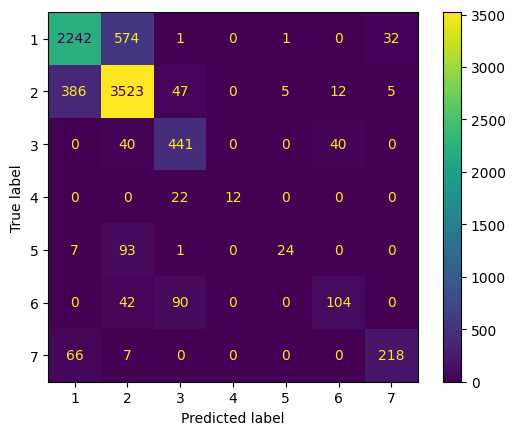

Log loss of Lr: 0.678791609797129
Accuracy of Lr is 0.7028002489110143


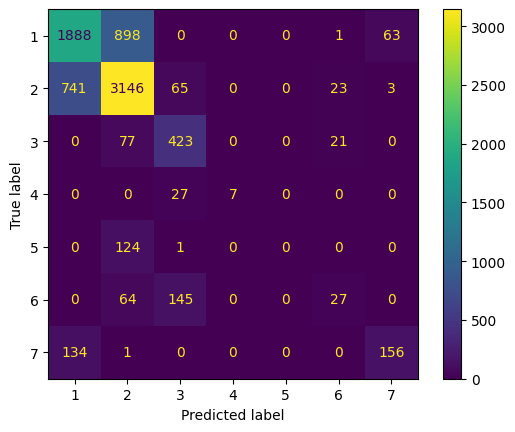

Log loss of ExtraTree: 0.2751090721395433
Accuracy of ExtraTree is 0.8927193528313628


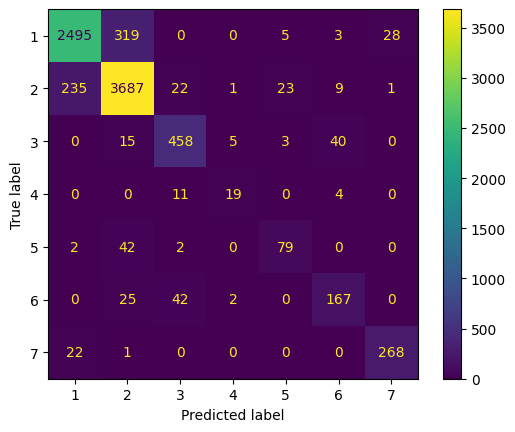

Log loss of Naive Bayes: 2.023007797669375
Accuracy of Naive Bayes is 0.5683883011823273


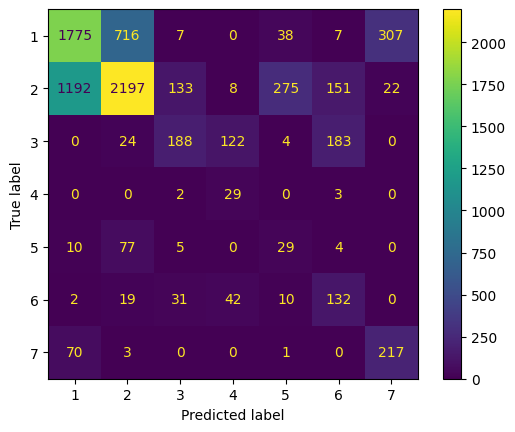

Log loss of Gradient Boost: 0.4617706737506961
Accuracy of Gradient Boost is 0.8593652769135034


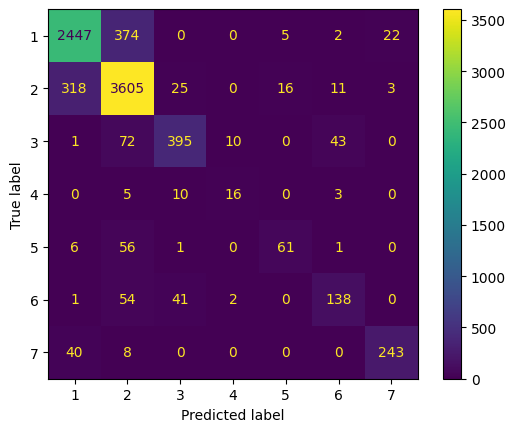

Log loss of Hgb: 0.32933181558343994
Accuracy of Hgb is 0.8744243932794026


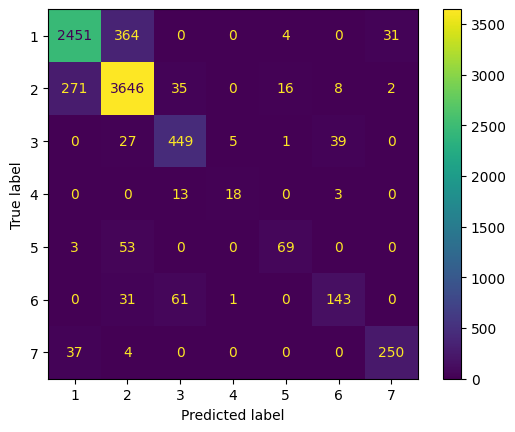

,Log_loss,Test accuracy
kNN,0.452543,0.816926
Lr,0.678792,0.702800
ExtraTree,0.275109,0.892719
Naive Bayes,2.023008,0.568388
Gradient Boost,0.461771,0.859365
Hgb,0.329332,0.874424


In [7]:
Resultats = []
for model_name, model in Model.items():
    pred_prob_train = pd.DataFrame(model.predict_proba(X_test_sub))
    loss = log_loss(y_test, pred_prob_train)
    print(f'Log loss of {model_name}: {loss}')

    y_pred = model.predict(X_test_sub)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name} is {test_accuracy}")
    
    Resultats.append([loss, test_accuracy])

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

result = pd.DataFrame(Resultats, columns=["Log_loss", "Test accuracy"], index=Model.keys())
result

### Rapport de classification de chaque modèle

In [8]:
for model_name, model in Model.items():
    y_pred = model.predict(X_test_sub)
    print(f"Classification report of {model_name}\n", classification_report(y_test, y_pred))

Classification report of kNN
               precision    recall  f1-score   support

           1       0.83      0.79      0.81      2850
           2       0.82      0.89      0.85      3978
           3       0.73      0.85      0.79       521
           4       1.00      0.35      0.52        34
           5       0.80      0.19      0.31       125
           6       0.67      0.44      0.53       236
           7       0.85      0.75      0.80       291

    accuracy                           0.82      8035
   macro avg       0.82      0.61      0.66      8035
weighted avg       0.82      0.82      0.81      8035

Classification report of Lr
               precision    recall  f1-score   support

           1       0.68      0.66      0.67      2850
           2       0.73      0.79      0.76      3978
           3       0.64      0.81      0.72       521
           4       1.00      0.21      0.34        34
           5       0.00      0.00      0.00       125
           6       

C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jerom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334

Classification report of ExtraTree
               precision    recall  f1-score   support

           1       0.91      0.88      0.89      2850
           2       0.90      0.93      0.91      3978
           3       0.86      0.88      0.87       521
           4       0.70      0.56      0.62        34
           5       0.72      0.63      0.67       125
           6       0.75      0.71      0.73       236
           7       0.90      0.92      0.91       291

    accuracy                           0.89      8035
   macro avg       0.82      0.79      0.80      8035
weighted avg       0.89      0.89      0.89      8035

Classification report of Naive Bayes
               precision    recall  f1-score   support

           1       0.58      0.62      0.60      2850
           2       0.72      0.55      0.63      3978
           3       0.51      0.36      0.42       521
           4       0.14      0.85      0.25        34
           5       0.08      0.23      0.12       125
    

### Random Forest et ses résultats (Mis à part car prend beaucoup plus de temps par rapport aux autres modèles)

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.0s
[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.1s
[Pipeline] .......... (step 2 of 4) Processing to_dense, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.1s
[Pipeline] ................ (step 4 of 4) Processing rf, total=14.9min
Log loss of random forest: 0.2898170168090797


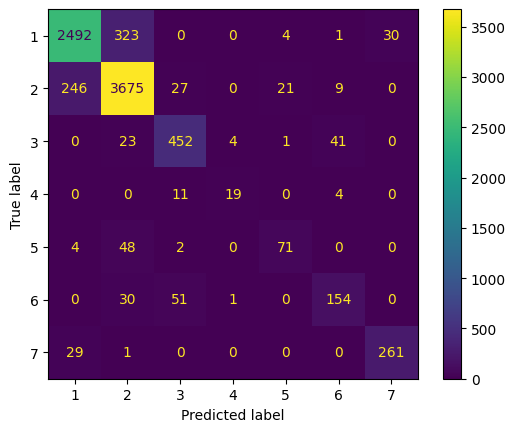

Classification report of Hgb
               precision    recall  f1-score   support

           1       0.90      0.87      0.89      2850
           2       0.90      0.92      0.91      3978
           3       0.83      0.87      0.85       521
           4       0.79      0.56      0.66        34
           5       0.73      0.57      0.64       125
           6       0.74      0.65      0.69       236
           7       0.90      0.90      0.90       291

    accuracy                           0.89      8035
   macro avg       0.83      0.76      0.79      8035
weighted avg       0.89      0.89      0.89      8035



In [9]:
rf = Pipeline(steps = [('preprocessor', preprocessor),
                         ('to_dense', DenseTransformer()),
                         ('pca', PCA(n_components=0.965, svd_solver= 'full', n_oversamples=100)),
                         ('rf', RandomForestClassifier(n_estimators=5000, max_depth=400, min_samples_split=2, min_samples_leaf=1,
                                                     criterion= 'entropy')),
                         ],
                         verbose = True)
rf.fit(X_train_sub, y_train.values.ravel())
pred_prob_train = pd.DataFrame(rf.predict_proba(X_test_sub))
loss = log_loss(y_test, pred_prob_train)
print(f'Log loss of random forest: {loss}')
y_pred = rf.predict(X_test_sub)
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()
print(f"Classification report of Random forest \n", classification_report(y_test, y_pred))

In [10]:
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of RandomForest is {test_accuracy}")

Accuracy of RandomForest is 0.8866210329807094
